#### CSCE 670 :: Information Storage and Retrieval :: Texas A&M University :: Spring 2018


# Homework 1:  Basic Machine Learning + Learning to Rank 

### 100 points [5% of your final grade]

### Due: Monday, February 12 by 11:59pm

*Goals of this homework:* In this homework you will get hands-on experience with (i) the basics of machine learning (e.g. train/test data, cross-validation, different classifiers) and interpreting results; and (ii) learning to rank.

*Submission Instructions:* To submit your homework, rename this notebook as UIN_hw#.ipynb. For example, this homework submission would be: YourUIN_hw1.ipynb. Submit this notebook via ecampus. Your notebook should be completely self-contained, with the results visible in the notebook. 

*Late submission policy:* For this homework, you may use up to three of your late days, meaning that no submissions will be accepted after Thursday, February 15 at 11:59pm.

*Collaboration policy:* You are expected to complete each homework independently. Your solution should be written by you without the direct aid or help of anyone else. However, we believe that collaboration and team work are important for facilitating learning, so we encourage you to discuss problems and general problem approaches (but not actual solutions) with your classmates. You may post on Piazza, search StackOverflow, etc. But if you do get help in this way, you must inform us by **filling out the Collaboration Declarations at the bottom of this notebook**. 

*Example: I found helpful code on stackoverflow at https://stackoverflow.com/questions/11764539/writing-fizzbuzz that helped me solve Problem 2.*

The basic rule is that no student should explicitly share a solution with another student (and thereby circumvent the basic learning process), but it is okay to share general approaches, directions, and so on. If you feel like you have an issue that needs clarification, feel free to contact either me or the TA.

# Part 1: Basics of ML (70 points)

For this part, we're going to get familiar with scikit-learn (a great ML toolkit that is very popular) and the major issues in training a model, testing it, and interpreting the results. Our goal in this assignment is to build a classifier to determine if a Yelp review is "food-relevant" or not.

## Dataset: Yelp review data

First, you will need to download the training_data.json file from the Resources tab on Piazza, a collection of 40,000 json-encoded Yelp reviews we sampled from the [Yelp Dataset Challenge](https://www.yelp.com/dataset_challenge).

You'll see that each line corresponds to a review on a particular business. The label (class) information of each review is in the "label" field. It is **either "Food-relevant" or "Food-irrelevant"**.

## Part 1.1: Parsing Yelp (15 points)

For this first part, we will build a parser for extracting tokens from the **review text** only. First, you should tokenize each review using **whitespaces and punctuations as delimiters**. Do not remove stopwords. You should apply casefolding (lower case everything) and use the [nltk Porter stemmer](http://www.nltk.org/api/nltk.stem.html#module-nltk.stem.porter) ... you may need to install nltk if you don't have it already. 

In [1]:
# your code here
# use as many cells as you need
import pandas as pd
import string
import nltk
from nltk.stem import PorterStemmer
from nltk import word_tokenize
# nltk.download('punkt')
data = pd.read_json('training_data.json', lines = True)
def yelp_parser(review):
    stemmer = PorterStemmer()
    review = ''.join(char for char in review if char not in set(string.punctuation))
    review = review.lower().split()
#     print len(review)
    token_list = [stemmer.stem(word).encode('ascii','ignore') for word in review]
#     print token_list
#     print len(token_list)
#     token_list = set(token_list)
#     print len(token_list)
    return token_list
def yelp_reviews_parser():
    reviews = data["text"]
    token_lists = []
    for r in reviews:
#         print r
        token_list = yelp_parser(r)
#         token_list = word_tokenize(r)
        token_lists.append(token_list)
#         print token_list
#         print len(token_list)
#     print len(token_lists)
    return token_lists
parsed_data = yelp_reviews_parser()    
    


### Unique tokens?

Once you have your parser working, you should report here the size of your feature space. That is, how many unique tokens do you find?

In [2]:
# your code here
import itertools
from itertools import chain
temp_list = list(itertools.chain.from_iterable(parsed_data))
print "Total tokens- " + str(len(temp_list))
unique_tokens = set(temp_list)
print "Feature Space Size (unique tokens)- " + str(len(unique_tokens))

Total tokens- 5009780
Feature Space Size (unique tokens)- 57334


### The Most Popular Words

Great, now we can tokenize the documents. Let's make a list of the most popular words in our reviews. For this step, you should maintain a count of how many times each word occurs. Then you should print out the top-20 words in your reviews.

Your output should look like this:

Rank Token Count

1 awesome 78

... ...

In [3]:
# your code here
import collections
from collections import Counter
counts = Counter(temp_list)
print "Rank  " +"Token  "+"Count" 
i = 1
for token, count in counts.most_common(20):
    print str(i)+"      "+str(token)+"   "+str(count)
    i += 1


Rank  Token  Count
1      the   245493
2      and   167505
3      i   147193
4      a   134001
5      to   127542
6      it   77943
7      of   76007
8      wa   73925
9      is   63418
10      for   60732
11      in   59622
12      that   50590
13      my   50439
14      they   41132
15      you   40565
16      thi   39699
17      with   39271
18      have   39030
19      but   37235
20      on   35061


### Zipf's Law

Recall in class our discussion of Zipf's law. Let's see if this law applies to our Yelp reviews. You should use matplotlib to plot the log-base10 term counts on the y-axis versus the log-base10 rank on the x-axis. Your aim is to create a figure like the one in Figure 5.2 of the textbook.

Text(0,0.5,u'log10cf')

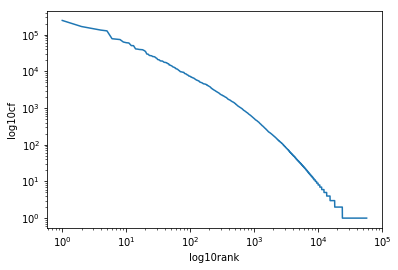

In [4]:
# your code here
%matplotlib inline  

import matplotlib.pyplot as plt  
rank_plot = []
count_plot = []
i = 1
for token, count in counts.most_common():
    rank_plot.append(i)
    count_plot.append(count)
    i += 1
x = rank_plot  
y = count_plot
plt.plot(x, y)
plt.xscale('log', basex=10)
plt.yscale('log', basey=10)
plt.xlabel('log10rank')
plt.ylabel('log10cf')


#### What do you observe? Is this consistent with Zipf's law?

In this graph, the frequency(log-base10 counts) is plotted as a function of frequency rank(log-base10 ranks) for the terms in the reviews. Yes, the Zipf's law holds for this collection of terms as the collection frequency of $i^{th}$ most common term is more or less proportional to $\frac{1}{i}$  
$cf_{i}\propto\frac{1}{i}$

## Part 1.2: Feature Represenation (10 points)

In this part you will build feature vectors for each review. This will be input to our ML classifiers. You should call your parser from earlier, using all the same assumptions (e.g., casefolding, stemming). Each feature value should be the term count for that review.

In [3]:
# your code
# from sklearn.feature_extraction.text import TfidfVectorizer
# vectorizer = TfidfVectorizer()
# vectors = vectorizer.fit_transform(yelp_parser(reviews[0]))
from sklearn.feature_extraction.text import CountVectorizer
parsed_data = yelp_reviews_parser() 
#Overriding the internal tokenizer and pre-processor of the CountVectorizer to use my own parsed tokens directly
vectorizer = CountVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: x) 
vectors = vectorizer.fit_transform(parsed_data)
print(vectors.shape)


(40000, 57334)


## Part 1.3: Machine Learning Basics (30 points)

In this part you will evaluate a bunch of classifiers -- kNN, Decision tree, Naive Bayes, and SVM -- on the feature vectors generated in the previous task in two different settings. **You do not need to implement any classifier from scratch. You may use scikit-learn's built-in capabilities.**

### Setting 1: Splitting data into train-test 

In the first setting, you should treat the first 70% of your data as training. The remaining 30% should be for testing. 

### Setting 2: Using 5 fold cross-validation

In the second setting, use 5-folk cross-validation. 

### What to report

* Report the overall accuracy for both settings.
* For the class "Food-relevant", report the precision and recall for both settings.
* For the class "Food-irrelevant", report the precision and recall for both settings.

In [15]:
# your code here...plus add cells for reporting your results
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn import metrics
import numpy as np
fr_labels = data['label'].map(lambda x: 1 if x == 'Food-relevant' else 0).values
# print encoded_labels

review_train, review_test, label_train, label_test = train_test_split(vectors, fr_labels, test_size=0.3, random_state=1337)
# print(review_train.shape, review_test.shape)

print "\n\n********Setting 1*********"
print "\n ###kNN Classifier (Prediction on 10000 due to memory constraints)###"
knnclassifier = KNeighborsClassifier()
knnclassifier.fit(review_train, label_train)
predictions = knnclassifier.predict(review_test[:10000])
print metrics.classification_report(label_test[:10000],predictions,target_names=['Food-relevant','Food-irrelevant'])
# print "Precision-"+str(metrics.precision_score(label_test, predictions))
# print "Recall-"+str(metrics.recall_score(label_test, predictions))
print "Accuracy-"+str(metrics.accuracy_score(label_test[:10000], predictions))
print " ###SVM Classifier###"
svmclassifier = LinearSVC()
svmclassifier.fit(review_train, label_train)
predictions = svmclassifier.predict(review_test)
print metrics.classification_report(label_test,predictions,target_names=['Food-relevant','Food-irrelevant'])
# print "Precision-"+str(metrics.precision_score(label_test, predictions))
# print "Recall-"+str(metrics.recall_score(label_test, predictions))
print "Accuracy-"+str(metrics.accuracy_score(label_test, predictions))
print "\n ###Decision Tree Classifier###"
dtclassifier = DecisionTreeClassifier()
dtclassifier.fit(review_train, label_train)
predictions = dtclassifier.predict(review_test)
print metrics.classification_report(label_test,predictions,target_names=['Food-relevant','Food-irrelevant'])
# print "Precision-"+str(metrics.precision_score(label_test, predictions))
# print "Recall-"+str(metrics.recall_score(label_test, predictions))
print "Accuracy-"+str(metrics.accuracy_score(label_test, predictions))
print "\n ###Multinomial Naive Bayes Classfier###"
nbclassifier = MultinomialNB()
nbclassifier.fit(review_train, label_train)
predictions = nbclassifier.predict(review_test)
print metrics.classification_report(label_test,predictions,target_names=['Food-relevant','Food-irrelevant'])
# print "Precision-"+str(metrics.precision_score(label_test, predictions))
# print "Recall-"+str(metrics.recall_score(label_test, predictions))
print "Accuracy-"+str(metrics.accuracy_score(label_test, predictions))






********Setting 1*********

 ###kNN Classifier###
                 precision    recall  f1-score   support

  Food-relevant       0.81      0.62      0.70      4954
Food-irrelevant       0.70      0.86      0.77      5046

    avg / total       0.75      0.74      0.74     10000

Accuracy-0.7394
 ###SVM Classifier###
                 precision    recall  f1-score   support

  Food-relevant       0.94      0.94      0.94      5952
Food-irrelevant       0.94      0.94      0.94      6048

    avg / total       0.94      0.94      0.94     12000

Accuracy-0.939583333333

 ###Decision Tree Classifier###
                 precision    recall  f1-score   support

  Food-relevant       0.88      0.89      0.88      5952
Food-irrelevant       0.89      0.88      0.89      6048

    avg / total       0.89      0.89      0.89     12000

Accuracy-0.885416666667

 ###Multinomial Naive Bayes Classfier###
                 precision    recall  f1-score   support

  Food-relevant       0.95      0.94

In [17]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

kf = KFold(n_splits=5, random_state=4, shuffle=False) 
kf.get_n_splits(vectors)
# print(kf) 

for train_index, test_index in kf.split(vectors):
    review_train, review_test = vectors[train_index], vectors[test_index]
    label_train, label_test = fr_labels[train_index], fr_labels[test_index]


# print(review_train.shape, review_test.shape)

print "********Setting 2*********"
print "\n ###kNN Classifier###"
knnclassifier = KNeighborsClassifier()
knnclassifier.fit(review_train, label_train)
predictions = cross_val_predict(knnclassifier,review_train,label_train)
print metrics.classification_report(label_train,predictions,target_names=['Food-relevant','Food-irrelevant'])
# print "Precision-"+str(np.mean(cross_val_score(knnclassifier, review_train, label_train, cv=5, scoring='precision')))
# print "Recall-"+str(np.mean(cross_val_score(knnclassifier, review_train, label_train, cv=5, scoring='recall')))
print "Accuracy-"+str(np.mean(cross_val_score(knnclassifier, review_train, label_train, cv=5)))

print " ###SVM Classifier###"
svmclassifier = LinearSVC()
svmclassifier.fit(review_train, label_train)
predictions = cross_val_predict(svmclassifier,review_train,label_train)
print metrics.classification_report(label_train,predictions,target_names=['Food-relevant','Food-irrelevant'])
# print "Precision-"+str(np.mean(cross_val_score(svmclassifier, review_train, label_train, cv=5, scoring='precision')))
# print "Recall-"+str(np.mean(cross_val_score(svmclassifier, review_train, label_train, cv=5, scoring='recall')))
print "Accuracy-"+str(np.mean(cross_val_score(svmclassifier, review_train, label_train, cv=5)))

print "\n ###Decision Tree Classifier###"
dtclassifier = DecisionTreeClassifier()
dtclassifier.fit(review_train, label_train)
predictions = cross_val_predict(dtclassifier,review_train,label_train)
print predictions.shape
print metrics.classification_report(label_train,predictions,target_names=['Food-relevant','Food-irrelevant'])

# print "Precision-"+str(np.mean(cross_val_score(dtclassifier, review_train, label_train, cv=5, scoring='precision')))
# print "Recall-"+str(np.mean(cross_val_score(dtclassifier, review_train, label_train, cv=5, scoring='recall')))
print "Accuracy-"+str(np.mean(cross_val_score(dtclassifier, review_train, label_train, cv=5)))

print "\n ###Multinomial Naive Bayes Classfier###"
nbclassifier = MultinomialNB()
nbclassifier.fit(review_train, label_train)
predictions = cross_val_predict(nbclassifier,review_train,label_train)
print metrics.classification_report(label_train,predictions,target_names=['Food-relevant','Food-irrelevant'])
# print "Precision-"+str(np.mean(cross_val_score(nbclassifier, review_train, label_train, cv=5, scoring='precision')))
# print "Recall-"+str(np.mean(cross_val_score(nbclassifier, review_train, label_train, cv=5, scoring='recall')))
print "Accuracy-"+str(np.mean(cross_val_score(nbclassifier, review_train, label_train, cv=5)))

********Setting 2*********

 ###kNN Classifier###
                 precision    recall  f1-score   support

  Food-relevant       0.76      0.39      0.52     12000
Food-irrelevant       0.72      0.93      0.81     20000

    avg / total       0.73      0.73      0.70     32000

Accuracy-0.7349375
 ###SVM Classifier###
                 precision    recall  f1-score   support

  Food-relevant       0.88      0.87      0.87     12000
Food-irrelevant       0.92      0.93      0.92     20000

    avg / total       0.91      0.91      0.91     32000

Accuracy-0.9106875

 ###Decision Tree Classifier###
(32000,)
                 precision    recall  f1-score   support

  Food-relevant       0.80      0.80      0.80     12000
Food-irrelevant       0.88      0.88      0.88     20000

    avg / total       0.85      0.85      0.85     32000

Accuracy-0.8603125

 ###Multinomial Naive Bayes Classfier###
                 precision    recall  f1-score   support

  Food-relevant       0.91      0.90

## Part 1.4: Analyzing your results (5 points) 

OK, now that you have tried four different classifiers, what do you observe? Any conclusions you can draw? Give us one or two paragraphs summarizing your findings.

*add your discussion here*

According to the classification scores obtained: **Multinomial Naive Bayes** emerges as the best classifier for this dataset, followed closely by **SVM Classifier (using a Linear kernel)**. The **Decision tree classifier** performs well. However, the **kNN Classifier** performs poorly.

**Precision** - the fraction of retrieved documents that are relevant
$$Precision =\frac{TP}{TP + FP}$$
**Recall** - the fraction of relevant documents that are retrieved 
$$Recall =\frac{TP}{TP + FN}$$
**Accuracy** -  the fraction of classifications that are correct
$$Accuracy =\frac{TP+TN}{TP + FN + FP + TN}$$
#### Multinomial Naive Bayes 
As the Multinomial Naive Bayes variation of the Naive Bayes algorithm is helpful when multiple occurrences of the words is important in the classification problem, it performs the best on this dataset. Also, the multinomial classifier naturally handles texts of varying length by incorporating the conditional probability of a particular word for a class by computing the relative frequency of term in documents belonging to that class (incldung multiple occurrences). On the other hand, it makes the assumption of conditional independence of the features which is not likely true for this dataset (as the words in the reviews are obviously related in terms of food choices, restaurants etc.) 
#### SVM Classifier
Even though, the Linear SVM classifier is widely regarded as one of the best text classfication algorithm it falls short of the performance achieved by MNB and is slightly slow when compared to it. The data in this problem is linearly separable aiding linear SVM to performs so well.Also, due to a high dimensional feature space, sparse document vectors and few irrelevant features, SVM thrives in this problem as it does not need aggressive feature selection.
#### Decision Tree Classifier
Decision trees are easy to interpret and generate predcitions fast. Near the top of the decision tree it is possible for the learning algorithm to find very useful features. However, most likely in this case since the stop words were not removed, they may have appeared at the top of the tree leading to inaccurate predictions. 
Decision trees force features to be checked in a specific order, even when features may be independent of one another, which leads to repetition of these features in the lower branches of the tree(due to space limitation at the top of the tree.) This is overcome by Naive Bayes which may be the reason for its higher accuracy.  
#### kNN Classifier
Classifiers like Bayesian, Support Vector Machine and Decision Tree are "eager learners", because they first build a classification model on the training dataset before actually classifying a sample from the test dataset. However, kNN is a "lazy classifier" and directly learns from the training instances, processing data only after it is given a test observation to classify. It requires frequent database lookups and therefore, is computationally expensive. kNN is also very sensitive to bad features and thus, feature selection is neccessary (which was not performed). kNN is sensitive to outliers and for a higher dimensional space approximation is used (which was not performed). These problems led to a poor performance on this dataset.

## Part 1.5: Improving your classifier (10 points)

I think we can do better! In this part, your job is to create new features that you can think can help improve your classifier. You may choose to use new weightings for your words, new derived features (e.g., count of 3-letter words), or whatever you like. You may also add in the extra features in the json: funny, useful, cool. You will need to experiment with different approaches ... once you finalize on your best approach, include the features here with a description (that is, tell us what the feature means). Then give us your classifier results!

### Features/Techniques that can help improve the classifier
#### Removal of stopwords
The most commmon words in the language(here English) like 'the', 'and' etc. can be removed as they take up space and eat up valuable processing time without adding any value to the classification. This helped in bringing the feature space size down significantly and improving the classification scores.
In this part, I used the default "english" stop list provided in sklearn's TfidfVectorizer function by specifying the "stop_words" parameter. 
#### Using  Term Frequency–Inverse Document Frequency instead of Term Counts
After removing the stopwords, I used the feature extractor TfidfVectorizer to transform th review text to feature vectors. Tf-idf is one of the most popularly used term-weighing schemes in information retrieval and is effective in emphasizing the most important words for a given document. The Tf-idf value is a combination of the term frequency and inverse document frequency. The tf-idf value increases proportionally to the number of times a word appears in the document. However, this is offset by the frequency of the word in the vocabulary taking into account the fact that some words appear more frequently in general. Tuning parameters such as min_df (which ignores terms that have a frequency strictly lower than the given threshold) also helps in improving the classification results. 
#### Adding bigrams and trigrams
Using the TfidfVectorizer parameter "n_gramrange", I extracted bigrams(2 words occuring frequently together) and trigrams (3 words occuring frequently together) leading to better classficiation scores and accuracy as higher order ngrams usually carry more information about the context in general which help in classification easily. 
#### Tuning the hyperparameters for a classifier
Tuning hyperparameters specific to a classifier can also help in improving the classification results.
#### Adding Parts of Speech Tagging
Using a Parts of Speech(POS) tagger (labelling words with their appropriate Part-Of-Speech like Noun, Verb, Adjective) can also help in improving the classification results. This technique was not explored due to time constraints.
#### Augmenting the vocabulary with higher weights for Food-related words
Assigning higher weights to words related to food as seen in the most informative features section can help in further improving the results. This technique was not explored due to time constraints.
#### Feature Selection
Most informative features can be selected through univariate feature selection, chi2 and f-value tests.

In [4]:
# your code here ... add as many cells as you need for features, results, and discussion.
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn import metrics
import numpy as np
# parsed_data = yelp_reviews_parser() 
encoded_labels = data['label'].map(lambda x: 1 if x == 'Food-relevant' else 0).values

vectorizer = TfidfVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: x, ngram_range=(1,3), min_df=10, stop_words="english")
vectors = vectorizer.fit_transform(parsed_data)
print(vectors.shape)
review_train, review_test, label_train, label_test = train_test_split(vectors, encoded_labels, test_size=0.3, random_state=1337)
# print(review_train.shape, review_test.shape)

print "\n\n********Setting 1*********"
print "\n ###kNN Classifier (Prediction on 10000 due to memory constraints)###"
knnclassifier = KNeighborsClassifier()
knnclassifier.fit(review_train, label_train)
predictions = knnclassifier.predict(review_test[:10000])
print metrics.classification_report(label_test[:10000],predictions,target_names=['Food-relevant','Food-irrelevant'])
print "Accuracy-"+str(metrics.accuracy_score(label_test[:10000], predictions))
print " ###SVM Classifier###"
svmclassifier = LinearSVC()
svmclassifier.fit(review_train, label_train)
predictions = svmclassifier.predict(review_test)
print metrics.classification_report(label_test,predictions,target_names=['Food-relevant','Food-irrelevant'])
print "Accuracy-"+str(metrics.accuracy_score(label_test, predictions))
print "\n ###Decision Tree Classifier###"
dtclassifier = DecisionTreeClassifier()
dtclassifier.fit(review_train, label_train)
predictions = dtclassifier.predict(review_test)
print metrics.classification_report(label_test,predictions,target_names=['Food-relevant','Food-irrelevant'])
print "Accuracy-"+str(metrics.accuracy_score(label_test, predictions))
print "\n ###Multinomial Naive Bayes Classfier###"
nbclassifier = MultinomialNB()
nbclassifier.fit(review_train, label_train)
predictions = nbclassifier.predict(review_test)
print metrics.classification_report(label_test,predictions,target_names=['Food-relevant','Food-irrelevant'])
print "Accuracy-"+str(metrics.accuracy_score(label_test, predictions))



(40000, 39216)


********Setting 1*********

 ###kNN Classifier (Prediction on 10000 due to memory constraints)###
                 precision    recall  f1-score   support

  Food-relevant       0.51      0.19      0.28      4954
Food-irrelevant       0.51      0.82      0.63      5046

    avg / total       0.51      0.51      0.45     10000

Accuracy-0.5084
 ###SVM Classifier###
                 precision    recall  f1-score   support

  Food-relevant       0.95      0.96      0.96      5952
Food-irrelevant       0.96      0.95      0.96      6048

    avg / total       0.96      0.96      0.96     12000

Accuracy-0.9575

 ###Decision Tree Classifier###
                 precision    recall  f1-score   support

  Food-relevant       0.90      0.89      0.90      5952
Food-irrelevant       0.89      0.90      0.90      6048

    avg / total       0.90      0.90      0.90     12000

Accuracy-0.896583333333

 ###Multinomial Naive Bayes Classfier###
                 precision    recall  f

### BONUS: What are the most informative features in distinguishing these two classes?

In [32]:
# Your code here
from sklearn.feature_selection import SelectKBest, f_classif, chi2

feature_names = vectorizer.get_feature_names()
#Selecting the 20 most informative features

ch2 = SelectKBest(chi2, k=20)

train_data = ch2.fit_transform(review_train, label_train)
test_data = ch2.transform(review_test)
informative_feature_names = [feature_names[i] for i in ch2.get_support(indices=True)]
print "Most informative features according to Chi-squared test "
print informative_feature_names

anova = SelectKBest(f_classif, k=20)

train_data = anova.fit_transform(review_train, label_train)
test_data = anova.transform(review_test)
informative_feature_names = [feature_names[i] for i in anova.get_support(indices=True)]
print "Most informative features according to ANOVA F-value test "
print informative_feature_names



Most informative features according to Chi-squared test 
['airport', 'car', 'chees', 'chicken', 'delici', 'dish', 'dr', 'eat', 'food', 'fri', 'lunch', 'meal', 'menu', 'order', 'pizza', 'restaur', 'salad', 'sandwich', 'sauc', 'wine']
Most informative features according to ANOVA F-value test 
['chees', 'chicken', 'delici', 'dish', 'eat', 'flavor', 'food', 'fresh', 'fri', 'good', 'help', 'lunch', 'meal', 'menu', 'order', 'restaur', 'salad', 'sandwich', 'sauc', 'tast']


# Part 2: Learning to Rank (30 points)

For this part, we're going to play with some Microsoft LETOR data that has query-document relevance judgments. Let's see how learning to rank works in practice. 

First, you will need to download the MQ2008.zip file from the Resources tab on Piazza. This is data from the [Microsoft Research IR Group](https://www.microsoft.com/en-us/research/project/letor-learning-rank-information-retrieval/).

The data includes 15,211 rows. Each row is a query-document pair. The first column is a relevance label of this pair (0,1 or 2--> the higher value the more related), the second column is query id, the following columns are features, and the end of the row is comment about the pair, including id of the document. A query-document pair is represented by a 46-dimensional feature vector. Features are a numeric value describing a document and query such as TFIDF, BM25, Page Rank, .... You can find compelete description of features from [here](https://arxiv.org/ftp/arxiv/papers/1306/1306.2597.pdf).

The good news for you is the dataset is ready for analysis: It has already been split into 5 folds (see the five folders called Fold1, ..., Fold5).

For this assignment, we're going to leave our favorite scikit-learn and instead use [SVM-rank](https://www.cs.cornell.edu/people/tj/svm_light/svm_rank.html). This is the basic ranking SVM we talked about in class. You'll see that SVM-rank considers pairwise relevance between docs -- so based on the training data it will transform the data into pairs -- like D1 > D2 and then learn a separator.


## Part 2.1: Optimizing SVM-Rank (15 points)

First, you should explore how the different parameters affect the quality of the Ranking SVM. You'll see that you can vary the kernel function, the loss function and so forth. 

You should run SVM-Rank using the default options over each of the five folds. You should find the error on the test set (for example, depending on your settings, svm_rank_classify will give you the zero/one error statistics (that is, the number of correct pairs and the number of incorrect pairs). Report the average. 

Then try different parameters and report how they impact the quality of results. 

*add your results and discussion here*

## Results and Discussion
#### The following results were obtained by changing the parameters:
#### Configuration 1 (c = 20.0)
Zero/one-error on test set (average across the 5 folds) = 61.522
#### Configuration 2 (c = 20.0, loss function - 1)
Zero/one-error on test set (average across the 5 folds) = 61.522
#### Configuration 3 (c = 20.0, loss function - 2)
Zero/one-error on test set (average across the 5 folds) = 59.992
#### Configuration 4 (c = 20.0, w - 4, f - 10)
Zero/one-error on test set (average across the 5 folds) = 61.436
#### Configuration 5 (c = 10.0)
Zero/one-error on test set (average across the 5 folds) = 61.522
#### Configuration 6 (c = 100.0)
Zero/one-error on test set (average across the 5 folds) = 61.236
#### Configuration 7 (c = 1000.0)
Zero/one-error on test set (average across the 5 folds) = 61.436
#### Configuration 8 (c = 20.0, w - 2, f - 10)
Zero/one-error on test set (average across the 5 folds) = 61.35
#### Configuration 9 (c = 20.0, e - 0.1)
Zero/one-error on test set (average across the 5 folds) = 61.66

#### The kernel trick parameters were extremely slow for me (I left one overnight!!!). I tried experimenting with the gamma value for RBF kernel and d parameter for polynomial kernel. However, they were extremely time consuming (as mentioned on the SVM rank documentation page itself). I even tried SVM light to overcome this and the kernel trick options were working for that but I could not figure out a way to get it to report the zero/one error.
### Observations
#### C Parameter
Here C is a learning parameter and is one of the most important hyperparameters for SVM. It is used to adjust the trade off between training error and low testing error. Thus, a smaller C value (default-0.01) increases the number of training errors as the optimizer looks for a larger-margin separating hyperplane, even if that hyperplane misclassifies more points and a large C value the optimization will choose a smaller-margin hyperplane does a better job of getting all the training points classified correctly.
#### epsilon Parameter
This parameter controls the tolerance for termination criterion.
The larger the value is, the more errors are admitted in the solution.
#### The linear SVM kernel was computationally less intensive as compared to the other kernels
    


## Part 2.1: Noise! (15 points)

Now we're going to investigate whether the ranking SVM is easily influenced by noisy features. For example, what if some of the features you have are in error? Or what if you downloaded only a portion of a page to calculate a feature? (so the count of inlinks would be wrong)? 

In this case, add some noise to the features. What happens to the results? You may choose to add random noise throughout, noise to a single feature, noise to multiple features, etc. The choices are up to you. We aim to see what kind of exploration you conduct and what you conclude.

*add your results and discussion here*

## Results and Discussion
I created a python script(added below) to add noise (random, multiple features[Features 10|19|21|25|32|37|43] and single feature[26]) to the dataset  
#### The following configurations were tested after adding noise:
#### Configuration 1 (c = 20.0)
Zero/one-error on test set (average across the 5 folds) = 62.158(random noise), 61.604(multiple feature noise), 61.522(single feature noise)
#### Configuration 2 (c = 20.0, loss function - 1)
Zero/one-error on test set (average across the 5 folds) = 62.158(random noise), 61.604(multiple feature noise), 61.522(single feature noise)
#### Configuration 3 (c = 20.0, loss function - 2)
Zero/one-error on test set (average across the 5 folds) = 61.222(random noise), 60.586(multiple feature noise), 60.16(single feature noise)
#### Configuration 4 (c = 20.0, w - 4, f - 10)
Zero/one-error on test set (average across the 5 folds) = 62.288(random noise), 61.47(multiple feature noise), 61.308(single feature noise)

I was not able to detect signifcant changes in the results after adding noise to the dataset indicating that SVM is fairly robust and capable of handling noise in the dataset. Though, in case of random noise the error was higher than multiple feature noise and single feature noise. This was as expected. 


In [ ]:
import random
import re
import string
import sys
def random_digits():
    rand_str = ':0.'
    rand_str = rand_str + ''.join(random.choice(string.digits) for x in range(6))
    return rand_str
def m_replace(m):
    if m:
        l = m.group(0).split(':')
        l[1] = str(random_digits())
        return ''.join(l)

re1='(\\d)+'	# Any Single Digit 1
re2='(:)'	# Any Single Character 1
re3='([+-]?\\d*\\.\\d+)(?![-+0-9\\.])'	# Float 1
folds = ['Fold1','Fold2','Fold3','Fold4','Fold5']
for fold in folds:
    file = fold+"/train.txt"
    outfile = fold+"/train1.txt"
    if sys.argv[1] == 'random':
        rg = re.compile(re2+re3,re.IGNORECASE|re.DOTALL)
        with open(outfile, "w") as target:
            with open(file, "r") as source:
                    for line in source:
                        if random.choice([0,1]):
                            rand = str(random_digits())
                            line = rg.sub(rand,line,int(random.choice(string.digits)))
                        target.write(line)
    elif sys.argv[1] == 'multiple':
        re1 = '(10|19|21|25|32|37|43)'
        rg = re.compile(re1+re2+re3,re.IGNORECASE|re.DOTALL)
        with open(outfile, "w") as target:
            with open(file, "r") as source:
                    for line in source:
                        rand = str(random_digits())
                        line = rg.sub(m_replace,line)
                        target.write(line)
    elif sys.argv[1] == 'single':
        re1 = '(26)'
        rg = re.compile(re1+re2+re3,re.IGNORECASE|re.DOTALL)
        with open(outfile, "w") as target:
            with open(file, "r") as source:
                    for line in source:
                        rand = str(random_digits())
                        line = rg.sub(m_replace,line)
                        target.write(line)
    else:
        print "Add some arguments for the ype of noise - random, multiple, single"                        

## Collaboration declarations

*If you collaborated with anyone (see Collaboration policy at the top of this homework), you can put your collaboration declarations here.*
I consulted the following sources for this homework:
Piazza, sklearn documentation 

https://stackoverflow.com/questions/35867484/pass-tokens-to-countvectorizer

https://stackoverflow.com/questions/31175140/get-a-classification-report-stating-the-class-wise-precision-and-recall-for-mult

http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

https://de.dariah.eu/tatom/preprocessing.html

https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d

https://medium.com/tensorist/classifying-yelp-reviews-using-nltk-and-scikit-learn-c58e71e962d9

https://de.dariah.eu/tatom/preprocessing.html
